In [30]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install Pillow


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [49]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from skimage import data, color
import PIL
from skimage.filters import threshold_otsu

In [15]:
from google.colab import files
uploaded = files.upload()

Saving ktp2.jpeg to ktp2.jpeg


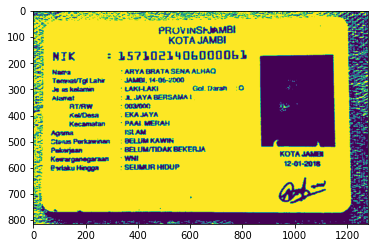

In [53]:
data_image = plt.imread('/content/ktp2.jpeg')

# Make the image grayscale using rgb2gray
data_image = color.rgb2gray(data_image)

# Obtain the optimal otsu global thresh value
global_thresh = threshold_otsu(data_image)

# Obtain the binary image by applying global thresholding
binary_global = data_image > global_thresh

plt.imshow(binary_global)

In [54]:
extractedInformation = pytesseract.image_to_string(binary_global)
print(extractedInformation)

NIK

Nara
TermavTgi Lah
Je 2s kelamn
Alarat
ATARWw
Kal/Desa
Kecamatan
Agama
Stavus Perkawinan
Pekarjaan
Kewarganegaraan

 

| LAKLLAKI

7 JAVA BERSAMA t
: Qoa70eR,

. EKA SAYA

* PAAL MERAH

PROUVINSPFJAMBI
KOTA JAMBI

> £5734021L40b0000b)1

1 ARYA BRATA SENA ALHAQ

JAMBI, 14-06-2000
Gat. Daran 0

ISLAM

: BELLA KAWIN

: BELUM/TIDAK BEKERJA
i]

: SEUMUR HIDUP

KOTA JAMEN
12-01-2018



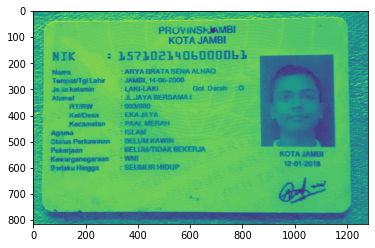

In [60]:
image_path_in_colab = "ktp2.jpeg"
img = Image.open(image_path_in_colab)

gray = color.rgb2gray(data_image)

# Obtain the optimal threshold value with otsu
thresh = threshold_otsu(gray)

# Apply thresholding to the image
binary = gray > thresh

plt.imshow(gray)

In [61]:
extractedInformation = pytesseract.image_to_string(gray)
print(extractedInformation)

OSError: ignored

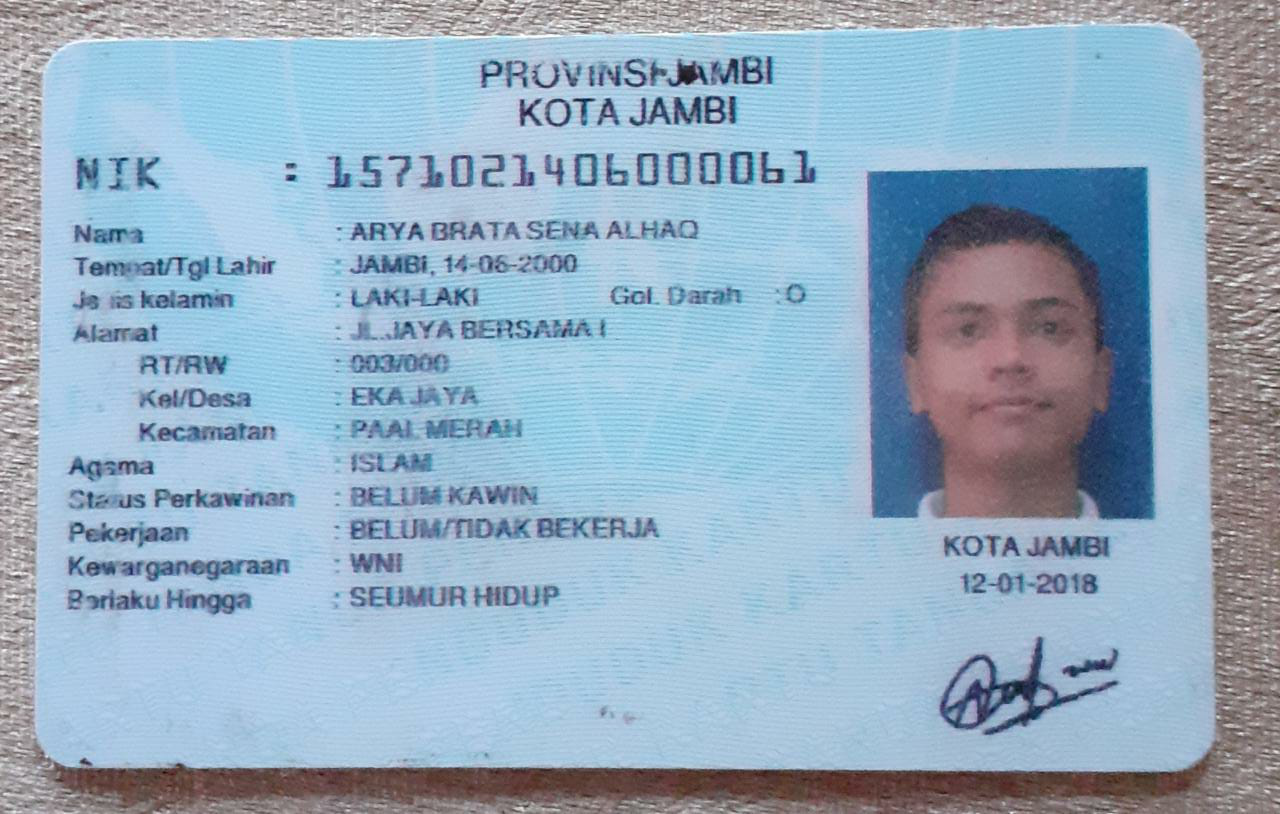

In [56]:
raw = Image.open(image_path_in_colab)
raw

In [57]:

extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))
print(extractedInformation)

      

 

== PROVINSFJAMBI

 

      

KOTA JAMBI
NIK : £571L02L40L0000b1
Nara - ARYA BRATA SENA ALHAQ
= Temeat/TgiLahir : JAMBi, 14-05-2000
== Js skelamin > LAKILAKI Gol Darah
Alamat : JLJAYA BERSAMA 1
- pna70e
> EKAJAYA
: PAALMERAH
» {STAM
> BELUM KAWIN
= Pekerjaan : BELUM/TIDAK BEXERJA e
: : KOTA JAMBI
= Kewar WNI
: — 12-01-2018

Boriaku Hingga : SEQMUR HIDUP

 



In [21]:
# Get bounding box estimates
print(pytesseract.image_to_boxes(Image.open(image_path_in_colab)))

~ 0 775 170 814 0
~ 386 798 437 814 0
~ 466 780 480 814 0
~ 705 808 746 814 0
~ 0 759 22 772 0
= 5 730 10 731 0
= 24 708 50 761 0
P 481 726 503 754 0
R 505 726 523 753 0
O 523 726 528 753 0
V 544 726 575 753 0
I 589 728 595 749 0
N 598 728 616 752 0
S 624 727 640 755 0
F 650 728 663 754 0
J 663 728 667 754 0
A 684 727 704 755 0
M 704 727 709 755 0
B 725 729 740 756 0
I 746 730 776 759 0
~ 0 568 55 735 0
~ 0 305 295 459 0
~ 0 420 52 492 0
~ 0 310 32 326 0
~ 864 341 1158 652 0
~ 864 294 943 341 0
~ 1110 294 1158 341 0
K 520 688 538 716 0
O 545 687 560 715 0
T 560 687 572 715 0
A 582 688 615 716 0
J 629 688 649 717 0
A 649 688 668 717 0
M 668 688 672 717 0
B 686 689 703 718 0
I 710 690 739 718 0
N 77 624 97 657 0
I 108 623 122 657 0
K 137 624 160 657 0
: 286 632 298 651 0
£ 327 626 353 658 0
5 360 626 382 658 0
7 388 627 412 658 0
1 420 626 429 659 0
L 429 626 438 659 0
0 451 627 466 659 0
2 482 627 505 659 0
L 513 628 535 659 0
4 545 628 563 659 0
0 575 628 599 661 0
L 606 628 629 661 0
